## Data Analysis of Simulation Results

This notebook contains code used to analyse the outputs of the Algorithm 1 of Appendix G in the paper. 

### R functions for reading the data

We first introduce functions that are used to read the data and turn the data into appropriate structure. The inputs used in the following functions are given as follows:
* *beta_a_demand, beta_b_demand*: $\alpha$ and $\beta$ parameters for the Beta arrival distribution of customers.
* *beta_a_supply, beta_b_supply*: $\alpha$ and $\beta$ parameters for the Beta arrival distribution of suppliers.
* *beta_specific*: $\text{rev_max} \in \{TRUE,FALSE\}$ indicates whether the data is to be filtered on the specified beta-distributed arrival parameters.
* *rev_max*: $\text{rev_max} \in \{TRUE,FALSE\}$ indicates whether the data to read is where the platform's objective function is revenue (if TRUE) or welfare. 

The following code defines a function called read_data that reads data from multiple files located in the "Submission Simulation Results/" directory, filters the files based on the specified beta-distributed arrival rates if the paramaeter beta_specific is set to TRUE, and combines the data into a single data.table. The combined data is returned as the output.

In [20]:
# Load required packages
require(data.table)
require(ggplot2)
require(gridExtra)
require(latex2exp)
require(ggnewscale)

# Define a function called 'readbeta_specific' with default parameter values
read_data = function(neq, beta_a_supply = 2, beta_b_supply = 2,
                             beta_a_demand = 2, beta_b_demand = 2, beta_specific = FALSE) {
  
  # List all files in the 'Submission Simulation Results/' directory and store the file paths in 'files'
  files = list.files('Submission Simulation Results/', full.names = T)
  
  # If 'beta_specific' is TRUE, filter 'files' to include only those that match the specified beta-distributed arrival rates
  if (beta_specific) {
    files = files[files %like% paste0('betasSD_', beta_a_supply, beta_b_supply, beta_a_demand, beta_b_demand)]
  }
  
  # Initialize an empty list called 'datlist'
  datlist = list()
  
  # Loop through each file in 'files'
  for (i in files) {
    # Read the file using 'fread' and store it in 'dd'
    dd = fread(i)
    
    # Append 'dd' to the 'datlist'
    datlist[[i]] = dd
  }
  
  # Combine all data.frames in 'datlist' into a single data.table called 'dat', filling missing columns with NA
  dat = rbindlist(datlist, fill = TRUE)
  
  # Return the combined data
  dat
}


This code defines a function called high_level_comparison_that reads data using the readall function, processes the data, and returns a summary of total welfare for various settings. The summary data is reshaped into a wide format using the dcast function from the data.table package.

In [104]:
# This function takes in two parameters: 'neq' and 'revmax' (default FALSE)
# It reads data from a source, processes it, and returns a reshaped summary
# of total welfare for various settings.
high_level_comparison = function(neq, revmax=FALSE,beta_a_supply = 2, beta_b_supply = 2,
                             beta_a_demand = 2, beta_b_demand = 2, beta_specific = FALSE) 
{
  # Read data from the source using the 'readall' function
  # with number of types 'neq', as argument, and store it in 'dat'
  if (!beta_specific)
  {
      dat = read_data(neq)
    }else
      {
      dat = read_data(neq,beta_a_supply, beta_b_supply,
                             beta_a_demand, beta_b_demand, beta_specific = TRUE)
  }
  
  # Replace all instances of 'epsilon' equal to 0.01 with 0.001
  dat[epsilon == 0.01, epsilon := 0.001]
  
  # Extract selected columns from 'dat' and store them in 'sn'
  sn = dat[, list(lambda_S, lambda_D, mu_S, mu_D, epsilon,
                  alpha, Setting, Beta_a = beta_a_supply, Beta_b = beta_b_supply,
                  Total_Welfare, Platform_Revenue, Type)]
  
  # If 'revmax' is TRUE, set 'alpha' to 0 for all rows with 'Setting' equal to "Decentralized"
  if (revmax) sn[Setting == "Decentralized", alpha := 0]
  
  # Remove any duplicate rows from 'sn'
  sn = sn[!duplicated(sn)]
  
  # Reshape 'sn' into a wide format, with 'Total_Welfare' as the value column
  dsn = dcast(sn, lambda_S + lambda_D + mu_S + mu_D + epsilon + alpha + Beta_a + Beta_b ~ Setting,
              value.var = 'Total_Welfare', fun.aggregate = min)
  dsn=dsn[!is.infinite(Centralized)][!is.infinite(Decentralized)]
  
  # Return the reshaped summary data
  dsn
}


The following code defines a function called centdecentheatmapall that accepts two parameters, the number of types neq=100 and revmax=FALSE. The function creates a heatmap plot using ggplot2 to visualize the welfare ratio between decentralized and centralized settings, with data filtered based on certain conditions. The plot can be saved to a file (though the file saving lines are currently commented out). This function is used in the paper to create Figures 10 and 11 that visualizes the welfare ratio between decentralized and centralized settings under varying market conditions.

In [18]:
# Define a function called 'centdecentheatmapall' with default parameters 'neq=100' and 'revmax=FALSE'
centdecentheatmapall = function(neq=100, revmax=FALSE) {
  
  # Call the 'high_level_comparison' function with the number of types 'neq' and 'revmax' as arguments
  # and store the result in 'dat'
  dat = high_level_comparison(neq, revmax)
  
  # Filter the data by removing rows with missing values
  # and only include market conditions tested for in Figures 10 and 11 
  dat = dat[!is.na(Centralized)][!is.na(Decentralized)][lambda_D != 100][!(Beta_a == 1 & Beta_b == 1)]
  
  # Calculate the 'Comparison' column as the ratio of 'Decentralized' to 'Centralized'
  # and create the 'Beta' column as a string describing the arrival distribution
  dat[, Comparison := Decentralized / Centralized][, Beta := paste0("Arrival distribution: Beta(", Beta_a, ",", Beta_b, ")")]
  
  # Round the minimum and maximum 'Comparison' values to one decimal place for better display in the legend
  dat[Comparison == max(Comparison), Comparison := round(Comparison, 1)]
  dat[Comparison == min(Comparison), Comparison := round(Comparison, 1)]
  
  # Create a ggplot2 plot based on the 'revmax' parameter value
  if (revmax) {
    ggplot(dat[alpha == 0], aes(x = as.factor(mu_S), y = as.factor(lambda_S / lambda_D), fill = Comparison)) +
      geom_tile() + labs(color = "Welfare Ratio", x = "Departure Rate", y = "Arrival Rate Ratio (Supply/Demand)", fill = "Welfare Ratio") +
      facet_wrap(Beta ~ .) +
      new_scale_color() +
      geom_text(aes(label = round(Comparison, 1), color = ifelse(Comparison <= 1, 0, 1)), show.legend = FALSE) +
      scale_color_gradient(low = "white", high = "black")
    # Save the plot to a file (commented out)
    # ggsave(filename = paste0("RobustnessPlots/RevenueMaximization_Heatmap_varyingarrivals.pdf"), height = 4.5)
  } else {
    ggplot(dat[alpha == 1], aes(x = as.factor(mu_S), y = as.factor(lambda_S / lambda_D), fill = Comparison)) +
      geom_tile() + labs(color = "Welfare Ratio", x = "Departure Rate", y = "Arrival Rate Ratio (Supply/Demand)", fill = "Welfare Ratio") +
      facet_wrap(Beta ~ .) + new_scale_color() +
      geom_text(aes(label = round(Comparison, 1), color = ifelse(Comparison <= 0.7, 0, 1)), show.legend = FALSE) +
      scale_color_gradient(low = "white", high = "black")
    # Save the plot to a file (commented out)
    # ggsave(filename = paste0("RobustnessPlots/WelfareMaximization_Heatmap_varyingarrivals.pdf"), height = 4.5)
  }
}


This code defines a function called epsilonmuheatmap that creates a heatmap plot using ggplot2 to visualize the welfare ratio between decentralized and centralized systems for varying mu and epsilon values. This function is used to create Figure 12 in the paper.

In [47]:
epsilonmuheatmap = function(neq=100, beta_a_supply=1, beta_b_supply=1, 
                            beta_a_demand=1, beta_b_demand=1, revmax=FALSE) {
  
  # Call the 'high_level_comparison' function with the given arguments and store the result in 'dat'
  dat = high_level_comparison(neq, revmax, beta_a_supply, beta_b_supply, beta_a_demand, beta_b_demand,TRUE)
  
  # Filter the data by removing rows with missing values for 'Centralized' and 'Decentralized'
  dat = dat[!is.na(Centralized)][!is.na(Decentralized)]
  
  # Calculate the 'Comparison' column as the ratio of 'Decentralized' to 'Centralized'
  dat[, Comparison := Decentralized / Centralized]
  
  # Create a new column 'lambda_D' as a string describing the buyer arrival rate
  dat[, lambda_D := paste0("Buyer arrival rate: ", lambda_D)]
  
  # Create a ggplot2 plot based on the 'revmax' parameter value (whether the platform is revenue-maximizing)
  if (revmax) {
    ggplot(dat[alpha == 0], aes(x = as.factor(epsilon), y = as.factor(mu_S), fill = Comparison)) +
      geom_tile() + labs(color = "Welfare Ratio", x = expression(epsilon), y = "Departure Rate", fill = "Welfare Ratio") +
      geom_text(aes(label = round(Comparison, 1), color = ifelse(Comparison <= 0.7, 0, 1)), show.legend = FALSE) +
      scale_color_gradient(low = "white", high = "black") + facet_wrap(~lambda_D)
    #ggsave(filename = paste0("RobustnessPlots/RevenueMax_mu_arrival_interaction.pdf"), height = 4.4)
  } else {
    ggplot(dat[alpha == 1], aes(x = as.factor(epsilon), y = as.factor(mu_S), fill = Comparison)) +
      geom_tile() + labs(color = "Welfare Ratio", x = expression(epsilon), y = "Departure Rate", fill = "Welfare Ratio") +
      geom_text(aes(label = round(Comparison, 1), color = ifelse(Comparison <= 0.7, 0, 1)), show.legend = FALSE) +
      scale_color_gradient(low = "white", high = "black") + facet_wrap(~lambda_D)
    #ggsave(filename = paste0("RobustnessPlots/WelfareMax_mu_arrival_interaction.pdf"), height = 4.4)
  }
}


### Creating the Figures 10-12 in the paper

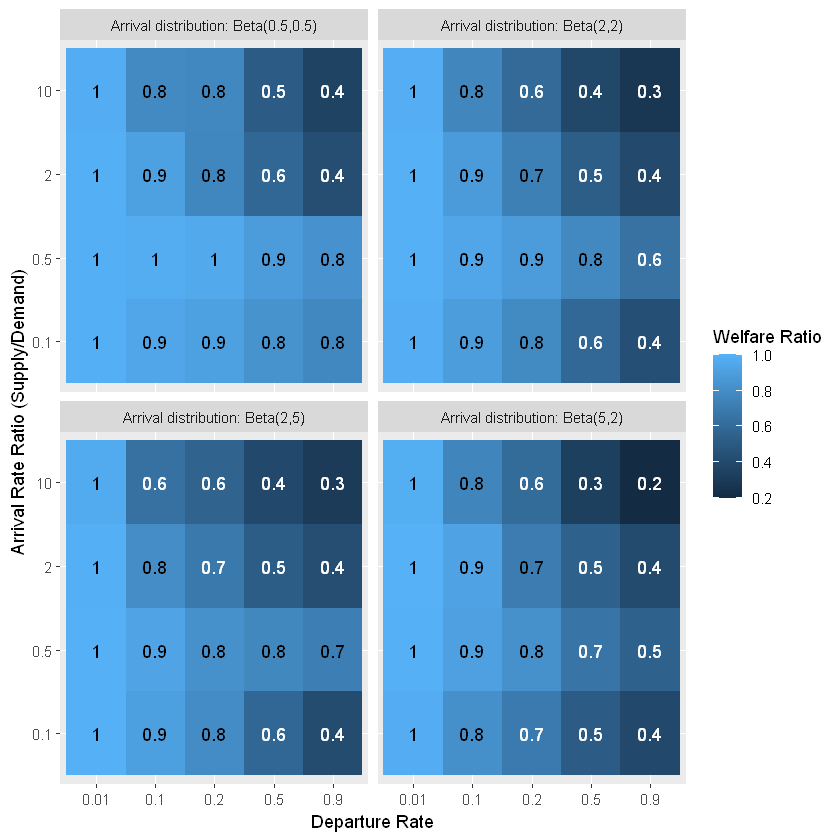

In [111]:
##Figure 10
centdecentheatmapall(revmax=TRUE)

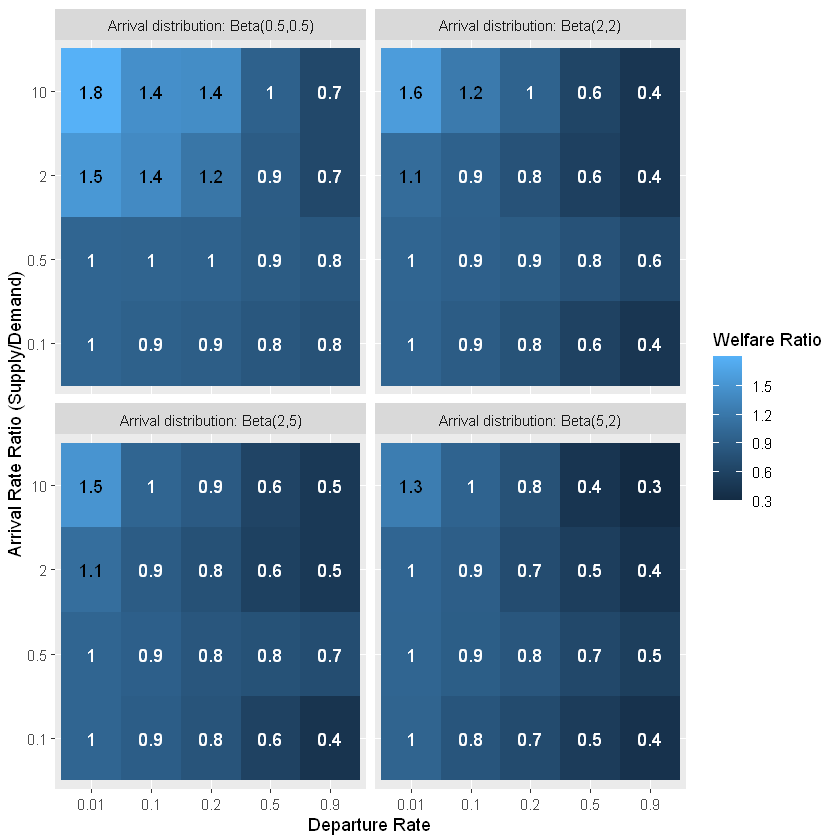

In [112]:
##Figure 11
centdecentheatmapall(revmax=TRUE)

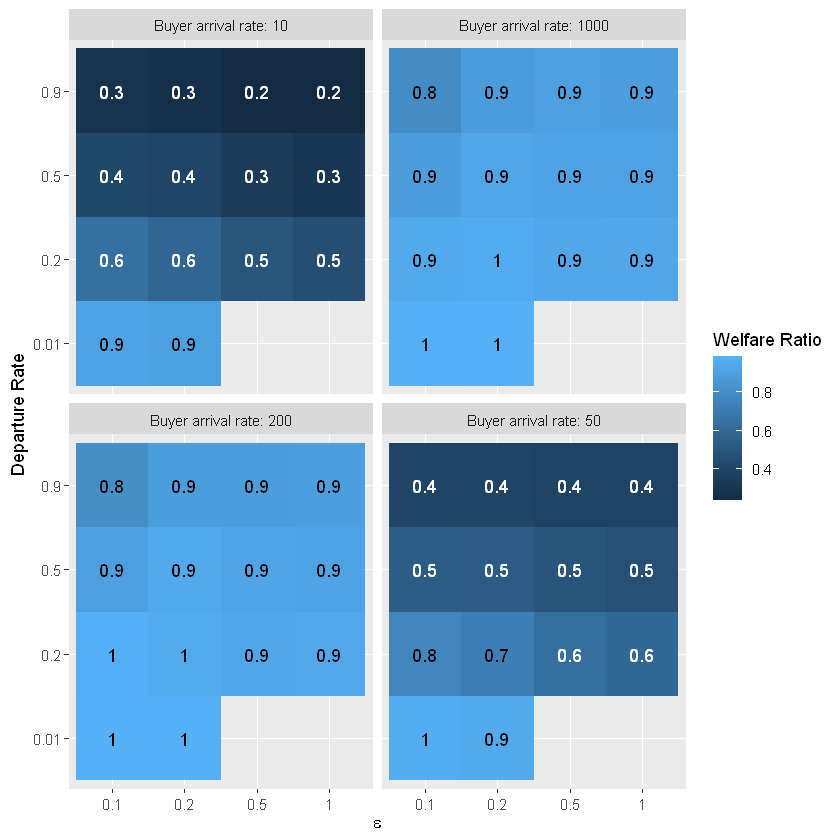

In [108]:
#Figure 12
epsilonmuheatmap()